## Modeling - digits dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.feature_selection import RFE, RFECV, VarianceThreshold, SelectFromModel, SelectKBest, mutual_info_classif
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from boruta import BorutaPy
# from lightgbm import LGBMClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, make_scorer
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import loguniform, uniform, randint

sns.set_style('whitegrid')
sns.set_palette('dark')

rs=123

In [2]:
# evaluation metric
def evaluation_metric(y_true, y_pred, m):
    """
    Balanced accuracy calculation with penalty depending on the number of features.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    ba = (1/2)*((tp/(tp+fn)) + (tn/(fp+tn)))
    penalty = 0.01*max(0, (1/200)*m - (1/4))
    return ba - penalty

### Data preparation

In [15]:
# loading data
x_train = pd.read_csv('./data/digits_train.data', sep=" ", header=None)
x_test = pd.read_csv('./data/digits_valid.data', sep=" ", header=None)
y_train = np.array(pd.read_csv('./data/digits_train.labels', header=None)[0].tolist())

In [16]:
# dropping unnecessary NaN columns
x_train.drop(columns=x_train.columns[-1], axis=1, inplace=True)
x_test.drop(columns=x_test.columns[-1], axis=1, inplace=True)

In [17]:
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,550,0,495,0,0,0,0,976,0,0,...,0,0,0,991,991,0,0,0,0,983
1,0,0,0,0,0,0,0,976,0,0,...,0,475,0,991,0,0,991,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,742,0,0,0,0,684,0,956,...,0,0,0,0,0,0,674,0,0,838
4,0,0,0,0,0,0,0,608,0,979,...,991,0,0,828,0,0,0,0,0,0


In [18]:
# data size
print('Train: ' , x_train.shape)
print('Test: ', x_test.shape)

Train:  (6000, 5000)
Test:  (1000, 5000)


-1    3000
 1    3000
dtype: int64


<AxesSubplot:ylabel='count'>

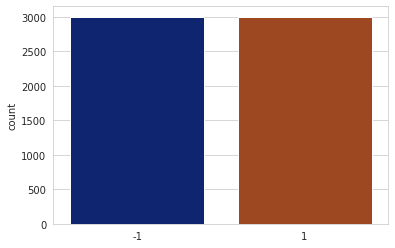

In [19]:
# target distribution
print(pd.Series(y_train).value_counts())
sns.countplot(y_train)

In [20]:
# train-valid split (stratification not needed - target perfectly balanced)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [21]:
# crossvalidation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1) 

In [22]:
# scaling - można spróbować innej metody i porównać
std = StandardScaler()
x_train_scaled = std.fit_transform(x_train)
x_valid_scaled = std.transform(x_valid)

### SelectKBest + Recursive Feature Elimination (RFE)

#### SelectKBest

In [23]:
k=100

In [24]:
selector = SelectKBest(score_func=mutual_info_classif, k=k)

selector.fit(x_train_scaled, y_train)

SelectKBest(k=100, score_func=<function mutual_info_classif at 0x7f97c640c1e0>)

In [25]:
x_train_kbest = selector.transform(x_train_scaled)

In [26]:
x_valid_kbest = selector.transform(x_valid_scaled)

#### Recursive Feature Elimination (RFE)

In [15]:
scores_ba = []
scores = []
n_of_features = np.arange(1,51,1)
for n in tqdm(n_of_features):
    clf = RandomForestClassifier(random_state=rs)
    rfe = RFE(clf, n_features_to_select=n)
    rfe.fit(x_train_kbest, y_train)
    x_train_rfe = rfe.transform(x_train_kbest)
    x_valid_rfe = rfe.transform(x_valid_kbest)
    rf = RandomForestClassifier(random_state=rs)
    rf.fit(x_train_rfe, y_train)
    y_pred = rf.predict(x_valid_rfe)
    scores_ba.append(balanced_accuracy_score(y_valid, y_pred))
    scores.append(evaluation_metric(y_valid, y_pred, x_valid_rfe.shape[1]))

100%|██████████| 50/50 [34:02<00:00, 40.85s/it]


In [16]:
results = pd.DataFrame([n_of_features, scores_ba, scores], 
                        index = ['No. of features', 'Balanced accuracy', 'Final score']).T
results.to_csv('./results_10/digits_rfe_results.csv', index=False)

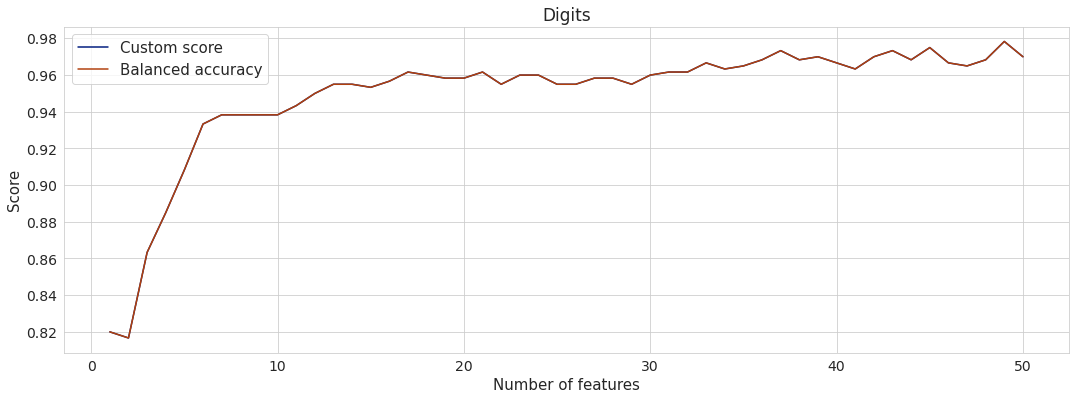

In [17]:
plt.figure(figsize=(18,6)) # pododawać jakieś legendy do tych plotów czy coś
sns.lineplot(x=n_of_features, y=scores, label='Custom score') # niebieska
sns.lineplot(x=n_of_features, y=scores_ba, label='Balanced accuracy') # brązowa
plt.xlabel('Number of features', size=15)
plt.ylabel('Score', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Digits', size=17)
plt.legend(fontsize=15)

In [8]:
# selecting only best scores for detailed analysis
ids_best = [i for i, elem in enumerate(scores) if elem > 0.97] # do zmiany na podstawie wyników !!!
scores_best = [round(elem, 5) for i, elem in enumerate(scores) if i in ids_best]
scores_ba_best = [round(elem, 5) for i, elem in enumerate(scores_ba) if i in ids_best]
n_of_features_best = [int(elem) for i, elem in enumerate(n_of_features) if i in ids_best]
best_results = pd.DataFrame([n_of_features_best, scores_ba_best, scores_best], 
                            index = ['No. of features', 'Balanced accuracy', 'Final score']).T
best_results = best_results.sort_values('No. of features').reset_index(drop=True)
best_results.style.background_gradient(cmap="Blues", axis=0)

,No. of features,Balanced accuracy,Final score
0,37.000000,0.973330,0.973330
1,43.000000,0.973330,0.973330
2,45.000000,0.975000,0.975000
3,49.000000,0.978330,0.978330


### SelectKBest + RFECV

#### Recursive Feature Elimination with cross-validation (RFECV)

In [19]:
clf = RandomForestClassifier(random_state=rs)

rfecv = RFECV(clf, step=1, cv=skf, scoring='balanced_accuracy')
# potrzebujemy jakos podać liczbe zmiennych wynikowych ale nie ma chyba jak tego zagnieździć :( 
# make_scorer(evaluation_metric, m=LICZBA ZMIENNYCH) (parametr evaluation metric, musi byc podany poza funkcja w tym przypadku)

rfecv = rfecv.fit(x_train_kbest, y_train)

In [20]:
x_train_rfecv = rfecv.transform(x_train_kbest)

In [21]:
x_valid_rfecv = rfecv.transform(x_valid_kbest)

In [22]:
x_valid_rfecv.shape[1]

89

In [23]:
rf = RandomForestClassifier(random_state=rs)
rf.fit(x_train_rfecv, y_train)

RandomForestClassifier(random_state=123)

In [24]:
balanced_accuracy_score(y_valid, rf.predict(x_valid_rfecv))

0.9683333333333333

In [25]:
evaluation_metric(y_valid, rf.predict(x_valid_rfecv), x_valid_rfecv.shape[1])

0.9663833333333333

### SelectKBest + Step Forward Feature Selection

#### Step Forward Feature Selection

In [26]:
clf = RandomForestClassifier(random_state=rs)
sfsf = SequentialFeatureSelector(clf,
           k_features='best', # zobaczyć co wypluje, jak słabo to testować 1-30 features tak jak dla rfe na przykład
            # chyba ze za długo sie bedzie liczył to od razu
           forward=True,
           floating=False,
           verbose=2,
           scoring='balanced_accuracy',
           cv=skf)

sfsf.fit(x_train_kbest, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished

[2022-05-30 00:10:18] Features: 1/100 -- score: 0.8331481481481482[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  1.4min finished

[2022-05-30 00:11:42] Features: 2/100 -- score: 0.8629629629629629[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  1.5min finished

[2022-05-30 00:13:10] Features: 3/100 -- score: 0.890925925925926[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                          estimator=RandomForestClassifier(random_state=123),
                          k_features='best', scoring='balanced_accuracy',
                          verbose=2)

In [27]:
x_train_sfsf = sfsf.transform(x_train_kbest)

In [28]:
x_valid_sfsf = sfsf.transform(x_valid_kbest)

In [29]:
x_valid_sfsf.shape[1]

50

In [30]:
rf = RandomForestClassifier(random_state=rs)
rf.fit(x_train_sfsf, y_train)

RandomForestClassifier(random_state=123)

In [31]:
balanced_accuracy_score(y_valid, rf.predict(x_valid_sfsf))

0.9583333333333333

In [32]:
evaluation_metric(y_valid, rf.predict(x_valid_sfsf), x_valid_sfsf.shape[1])

0.9583333333333333

### SelectKBest + Step Backward Feature Selection

#### Step Backward Feature Selection

In [27]:
clf = RandomForestClassifier(random_state=rs)
sfsb = SequentialFeatureSelector(clf,
           k_features='best', # zobaczyć co wypluje, jak słabo to testować 1-30 features tak jak dla rfe na przykład
            # chyba ze za długo sie bedzie liczył to od razu
           forward=False,
           floating=False,
           verbose=2,
           scoring='balanced_accuracy',
           cv=skf)

sfsb.fit(x_train_kbest, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.3min finished

[2022-05-30 08:26:21] Features: 99/1 -- score: 0.9553703703703704[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  4.2min finished

[2022-05-30 08:30:33] Features: 98/1 -- score: 0.9553703703703704[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  4.2min finished

[2022-05-30 08:34:48] Features: 97/1 -- score: 0.9546296296296296[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                          estimator=RandomForestClassifier(random_state=123),
                          forward=False, k_features='best',
                          scoring='balanced_accuracy', verbose=2)

In [28]:
x_train_sfsb = sfsb.transform(x_train_kbest)

In [29]:
x_valid_sfsb = sfsb.transform(x_valid_kbest)

In [30]:
x_valid_sfsb.shape[1]

78

In [31]:
rf = RandomForestClassifier(random_state=rs)
rf.fit(x_train_sfsb, y_train)

RandomForestClassifier(random_state=123)

In [32]:
balanced_accuracy_score(y_valid, rf.predict(x_valid_sfsb))

0.9666666666666667

In [33]:
evaluation_metric(y_valid, rf.predict(x_valid_sfsb), x_valid_sfsb.shape[1])

0.9652666666666667

### Boruta

In [34]:
max_depth = np.arange(2,16,1)
n_of_features = []
scores = []
scores_ba = []
for md in tqdm(max_depth):
    rf = RandomForestClassifier(class_weight='balanced', max_depth=md, random_state=rs) # z dokumentacji, można się pobawić moze coś zmieni
    rf.fit(x_train_scaled, y_train)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(np.array(x_train_scaled), y_train)    
    n_of_features.append(feat_selector.support_.sum())
    x_train_boruta = feat_selector.transform(np.array(x_train_scaled))
    x_valid_boruta = feat_selector.transform(np.array(x_valid_scaled))
    rf = RandomForestClassifier(random_state=rs) # moze próbowac grida zeby polepszyć
    rf.fit(x_train_boruta, y_train)
    scores_ba.append(balanced_accuracy_score(y_valid, rf.predict(x_valid_boruta)))
    scores.append(evaluation_metric(y_valid, rf.predict(x_valid_boruta), x_valid_boruta.shape[1]))

  0%|          | 0/14 [00:00<?, ?it/s]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	678
Tentative: 	900
Rejected: 	3422
Iteration: 	9 / 100
Confirmed: 	678
Tentative: 	900
Rejected: 	3422
Iteration: 	10 / 100
Confirmed: 	678
Tentative: 	900
Rejected: 	3422
Iteration: 	11 / 100
Confirmed: 	678
Tentative: 	900
Rejected: 	3422
Iteration: 	12 / 100
Confirmed: 	700
Tentative: 	721
Rejected: 	3579
Iteration: 	13 / 100
Confirmed: 	700
Tentative: 	721
Rejected: 	3579
Iteration: 	14 / 100
Confirmed: 	700
Tentative: 	721
Rejected: 	3579
Iteration: 	15 / 100
Confirmed: 	700
Tentative: 	721
Rejected: 	3579
It

  7%|▋         | 1/14 [23:24<5:04:21, 1404.70s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	941
Tentative: 	846
Rejected: 	3213
Iteration: 	9 / 100
Confirmed: 	941
Tentative: 	846
Rejected: 	3213
Iteration: 	10 / 100
Confirmed: 	941
Tentative: 	846
Rejected: 	3213
Iteration: 	11 / 100
Confirmed: 	941
Tentative: 	846
Rejected: 	3213
Iteration: 	12 / 100
Confirmed: 	968
Tentative: 	819
Rejected: 	3213
Iteration: 	13 / 100
Confirmed: 	968
Tentative: 	720
Rejected: 	3312
Iteration: 	14 / 100
Confirmed: 	968
Tentative: 	720
Rejected: 	3312
Iteration: 	15 / 100
Confirmed: 	968
Tentative: 	720
Rejected: 	3312
It

 14%|█▍        | 2/14 [52:26<5:20:33, 1602.82s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1079
Tentative: 	712
Rejected: 	3209
Iteration: 	9 / 100
Confirmed: 	1079
Tentative: 	712
Rejected: 	3209
Iteration: 	10 / 100
Confirmed: 	1079
Tentative: 	712
Rejected: 	3209
Iteration: 	11 / 100
Confirmed: 	1079
Tentative: 	712
Rejected: 	3209
Iteration: 	12 / 100
Confirmed: 	1108
Tentative: 	683
Rejected: 	3209
Iteration: 	13 / 100
Confirmed: 	1108
Tentative: 	576
Rejected: 	3316
Iteration: 	14 / 100
Confirmed: 	1108
Tentative: 	576
Rejected: 	3316
Iteration: 	15 / 100
Confirmed: 	1108
Tentative: 	576
Rejected: 

 21%|██▏       | 3/14 [1:21:54<5:07:41, 1678.36s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1149
Tentative: 	597
Rejected: 	3254
Iteration: 	9 / 100
Confirmed: 	1149
Tentative: 	597
Rejected: 	3254
Iteration: 	10 / 100
Confirmed: 	1149
Tentative: 	597
Rejected: 	3254
Iteration: 	11 / 100
Confirmed: 	1149
Tentative: 	597
Rejected: 	3254
Iteration: 	12 / 100
Confirmed: 	1171
Tentative: 	575
Rejected: 	3254
Iteration: 	13 / 100
Confirmed: 	1171
Tentative: 	502
Rejected: 	3327
Iteration: 	14 / 100
Confirmed: 	1171
Tentative: 	502
Rejected: 	3327
Iteration: 	15 / 100
Confirmed: 	1171
Tentative: 	502
Rejected: 

 29%|██▊       | 4/14 [1:52:18<4:49:17, 1735.75s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1156
Tentative: 	563
Rejected: 	3281
Iteration: 	9 / 100
Confirmed: 	1156
Tentative: 	563
Rejected: 	3281
Iteration: 	10 / 100
Confirmed: 	1156
Tentative: 	563
Rejected: 	3281
Iteration: 	11 / 100
Confirmed: 	1156
Tentative: 	563
Rejected: 	3281
Iteration: 	12 / 100
Confirmed: 	1170
Tentative: 	549
Rejected: 	3281
Iteration: 	13 / 100
Confirmed: 	1170
Tentative: 	472
Rejected: 	3358
Iteration: 	14 / 100
Confirmed: 	1170
Tentative: 	472
Rejected: 	3358
Iteration: 	15 / 100
Confirmed: 	1170
Tentative: 	472
Rejected: 

 36%|███▌      | 5/14 [2:21:42<4:21:54, 1746.03s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1117
Tentative: 	521
Rejected: 	3362
Iteration: 	9 / 100
Confirmed: 	1117
Tentative: 	521
Rejected: 	3362
Iteration: 	10 / 100
Confirmed: 	1117
Tentative: 	521
Rejected: 	3362
Iteration: 	11 / 100
Confirmed: 	1117
Tentative: 	521
Rejected: 	3362
Iteration: 	12 / 100
Confirmed: 	1139
Tentative: 	499
Rejected: 	3362
Iteration: 	13 / 100
Confirmed: 	1139
Tentative: 	425
Rejected: 	3436
Iteration: 	14 / 100
Confirmed: 	1139
Tentative: 	425
Rejected: 	3436
Iteration: 	15 / 100
Confirmed: 	1139
Tentative: 	425
Rejected: 

 43%|████▎     | 6/14 [2:49:52<3:50:15, 1726.93s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1125
Tentative: 	491
Rejected: 	3384
Iteration: 	9 / 100
Confirmed: 	1125
Tentative: 	491
Rejected: 	3384
Iteration: 	10 / 100
Confirmed: 	1125
Tentative: 	491
Rejected: 	3384
Iteration: 	11 / 100
Confirmed: 	1125
Tentative: 	491
Rejected: 	3384
Iteration: 	12 / 100
Confirmed: 	1137
Tentative: 	479
Rejected: 	3384
Iteration: 	13 / 100
Confirmed: 	1137
Tentative: 	409
Rejected: 	3454
Iteration: 	14 / 100
Confirmed: 	1137
Tentative: 	409
Rejected: 	3454
Iteration: 	15 / 100
Confirmed: 	1137
Tentative: 	409
Rejected: 

 50%|█████     | 7/14 [3:17:44<3:19:23, 1709.05s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1084
Tentative: 	488
Rejected: 	3428
Iteration: 	9 / 100
Confirmed: 	1084
Tentative: 	488
Rejected: 	3428
Iteration: 	10 / 100
Confirmed: 	1084
Tentative: 	488
Rejected: 	3428
Iteration: 	11 / 100
Confirmed: 	1084
Tentative: 	488
Rejected: 	3428
Iteration: 	12 / 100
Confirmed: 	1094
Tentative: 	478
Rejected: 	3428
Iteration: 	13 / 100
Confirmed: 	1094
Tentative: 	393
Rejected: 	3513
Iteration: 	14 / 100
Confirmed: 	1094
Tentative: 	393
Rejected: 	3513
Iteration: 	15 / 100
Confirmed: 	1094
Tentative: 	393
Rejected: 

 57%|█████▋    | 8/14 [3:44:36<2:47:48, 1678.14s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1025
Tentative: 	485
Rejected: 	3490
Iteration: 	9 / 100
Confirmed: 	1025
Tentative: 	485
Rejected: 	3490
Iteration: 	10 / 100
Confirmed: 	1025
Tentative: 	485
Rejected: 	3490
Iteration: 	11 / 100
Confirmed: 	1025
Tentative: 	485
Rejected: 	3490
Iteration: 	12 / 100
Confirmed: 	1035
Tentative: 	475
Rejected: 	3490
Iteration: 	13 / 100
Confirmed: 	1035
Tentative: 	388
Rejected: 	3577
Iteration: 	14 / 100
Confirmed: 	1035
Tentative: 	388
Rejected: 	3577
Iteration: 	15 / 100
Confirmed: 	1035
Tentative: 	388
Rejected: 

 64%|██████▍   | 9/14 [4:09:58<2:15:46, 1629.28s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	996
Tentative: 	497
Rejected: 	3507
Iteration: 	9 / 100
Confirmed: 	996
Tentative: 	497
Rejected: 	3507
Iteration: 	10 / 100
Confirmed: 	996
Tentative: 	497
Rejected: 	3507
Iteration: 	11 / 100
Confirmed: 	996
Tentative: 	497
Rejected: 	3507
Iteration: 	12 / 100
Confirmed: 	1005
Tentative: 	488
Rejected: 	3507
Iteration: 	13 / 100
Confirmed: 	1005
Tentative: 	400
Rejected: 	3595
Iteration: 	14 / 100
Confirmed: 	1005
Tentative: 	400
Rejected: 	3595
Iteration: 	15 / 100
Confirmed: 	1005
Tentative: 	400
Rejected: 	359

 71%|███████▏  | 10/14 [4:33:47<1:44:30, 1567.65s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	951
Tentative: 	490
Rejected: 	3559
Iteration: 	9 / 100
Confirmed: 	951
Tentative: 	490
Rejected: 	3559
Iteration: 	10 / 100
Confirmed: 	951
Tentative: 	490
Rejected: 	3559
Iteration: 	11 / 100
Confirmed: 	951
Tentative: 	490
Rejected: 	3559
Iteration: 	12 / 100
Confirmed: 	956
Tentative: 	485
Rejected: 	3559
Iteration: 	13 / 100
Confirmed: 	956
Tentative: 	403
Rejected: 	3641
Iteration: 	14 / 100
Confirmed: 	956
Tentative: 	403
Rejected: 	3641
Iteration: 	15 / 100
Confirmed: 	956
Tentative: 	403
Rejected: 	3641
It

 79%|███████▊  | 11/14 [4:56:31<1:15:15, 1505.13s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	956
Tentative: 	488
Rejected: 	3556
Iteration: 	9 / 100
Confirmed: 	956
Tentative: 	488
Rejected: 	3556
Iteration: 	10 / 100
Confirmed: 	956
Tentative: 	488
Rejected: 	3556
Iteration: 	11 / 100
Confirmed: 	956
Tentative: 	488
Rejected: 	3556
Iteration: 	12 / 100
Confirmed: 	964
Tentative: 	480
Rejected: 	3556
Iteration: 	13 / 100
Confirmed: 	964
Tentative: 	401
Rejected: 	3635
Iteration: 	14 / 100
Confirmed: 	964
Tentative: 	401
Rejected: 	3635
Iteration: 	15 / 100
Confirmed: 	964
Tentative: 	401
Rejected: 	3635
It

 86%|████████▌ | 12/14 [5:18:11<48:05, 1442.90s/it]  

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	913
Tentative: 	512
Rejected: 	3575
Iteration: 	9 / 100
Confirmed: 	913
Tentative: 	512
Rejected: 	3575
Iteration: 	10 / 100
Confirmed: 	913
Tentative: 	512
Rejected: 	3575
Iteration: 	11 / 100
Confirmed: 	913
Tentative: 	512
Rejected: 	3575
Iteration: 	12 / 100
Confirmed: 	922
Tentative: 	503
Rejected: 	3575
Iteration: 	13 / 100
Confirmed: 	922
Tentative: 	418
Rejected: 	3660
Iteration: 	14 / 100
Confirmed: 	922
Tentative: 	418
Rejected: 	3660
Iteration: 	15 / 100
Confirmed: 	922
Tentative: 	418
Rejected: 	3660
It

 93%|█████████▎| 13/14 [5:38:41<22:58, 1378.13s/it]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	5000
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	902
Tentative: 	527
Rejected: 	3571
Iteration: 	9 / 100
Confirmed: 	902
Tentative: 	527
Rejected: 	3571
Iteration: 	10 / 100
Confirmed: 	902
Tentative: 	527
Rejected: 	3571
Iteration: 	11 / 100
Confirmed: 	902
Tentative: 	527
Rejected: 	3571
Iteration: 	12 / 100
Confirmed: 	912
Tentative: 	417
Rejected: 	3671
Iteration: 	13 / 100
Confirmed: 	912
Tentative: 	417
Rejected: 	3671
Iteration: 	14 / 100
Confirmed: 	912
Tentative: 	417
Rejected: 	3671
Iteration: 	15 / 100
Confirmed: 	912
Tentative: 	417
Rejected: 	3671
It

100%|██████████| 14/14 [5:58:01<00:00, 1534.42s/it]


In [35]:
results = pd.DataFrame([max_depth, n_of_features, scores_ba, scores], 
                        index = ['Max depth','No. of features', 'Balanced accuracy', 'Final score']).T
results.to_csv('./results_10/digits_boruta_results.csv', index=False)

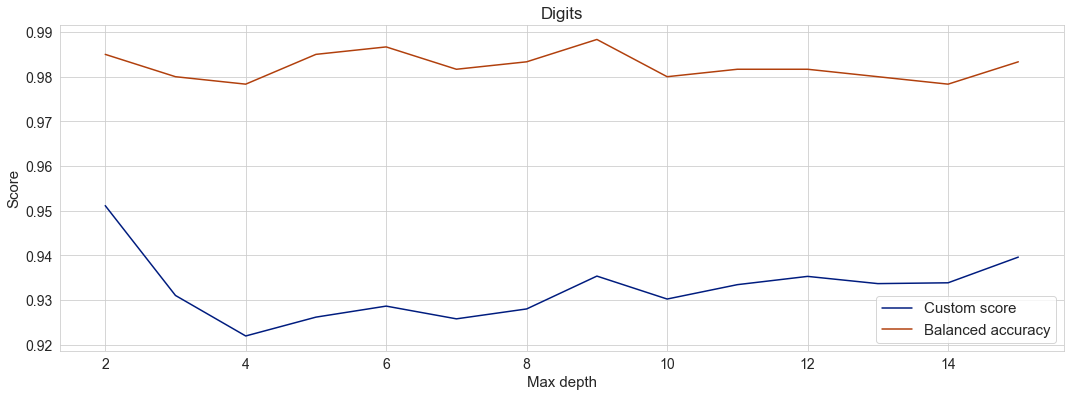

In [36]:
plt.figure(figsize=(18,6))
sns.lineplot(x=max_depth, y=scores, label='Custom score') # niebieska
sns.lineplot(x=max_depth, y=scores_ba, label='Balanced accuracy') # brązowa
plt.xlabel('Max depth', size=15)
plt.ylabel('Score', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Digits', size=17)
plt.legend(fontsize=15)

In [37]:
# selecting only best scores for detailed analysis
ids_best = [i for i, elem in enumerate(scores) if elem > 0.93] # próg do zmiany na podstawie wyników !!!
scores_best = [round(elem, 5) for i, elem in enumerate(scores) if i in ids_best]
scores_ba_best = [round(elem, 5) for i, elem in enumerate(scores_ba) if i in ids_best]
n_of_features_best = [int(elem) for i, elem in enumerate(n_of_features) if i in ids_best]
max_depth_best = [int(elem) for i, elem in enumerate(max_depth) if i in ids_best]
best_results = pd.DataFrame([max_depth_best, n_of_features_best, scores_ba_best, scores_best], 
                            index = ['Max depth', 'No. of features', 'Balanced accuracy', 'Final score']).T
best_results = best_results.sort_values('No. of features').reset_index(drop=True)
best_results.style.background_gradient(cmap="Blues", axis=0)

,Max depth,No. of features,Balanced accuracy,Final score
0,2.000000,727.000000,0.985000,0.951150
1,15.000000,924.000000,0.983330,0.939630
2,14.000000,939.000000,0.978330,0.933880
3,13.000000,976.000000,0.980000,0.933700
4,12.000000,977.000000,0.981670,0.935320
5,11.000000,1014.000000,0.981670,0.933470
6,3.000000,1029.000000,0.980000,0.931050
7,10.000000,1045.000000,0.980000,0.930250
8,9.000000,1109.000000,0.988330,0.935380


### L1

In [38]:
scores = []
scores_ba = []
n_of_features = []
cs = np.arange(0.0005, 0.05, 0.001)
for c in tqdm(cs):
    selector = SelectFromModel(LinearSVC(C=c, penalty="l1", dual=False, random_state=rs).fit(x_train_scaled, y_train), prefit=True)
    x_train_l1 = selector.transform(x_train_scaled)
    x_valid_l1 = selector.transform(x_valid_scaled)
    estimator = RandomForestClassifier(random_state=rs) 
    estimator.fit(x_train_l1, y_train)
    y_pred = estimator.predict(x_valid_l1)
    n_of_features.append(x_train_l1.shape[1])
    scores_ba.append(balanced_accuracy_score(y_valid, y_pred))
    scores.append(evaluation_metric(y_valid, estimator.predict(x_valid_l1), x_valid_l1.shape[1]))

100%|██████████| 50/50 [04:10<00:00,  5.02s/it]


In [39]:
results = pd.DataFrame([cs, n_of_features, scores_ba, scores], 
                        index = ['C','No. of features', 'Balanced accuracy', 'Final score']).T
results.to_csv('./results_10/digits_l1_results.csv', index=False)

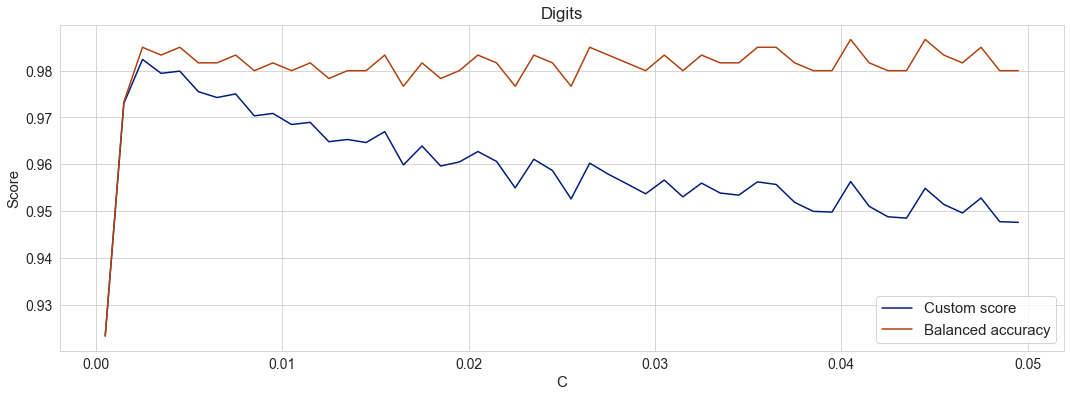

In [40]:
plt.figure(figsize=(18,6)) # pododawać jakieś legendy do tych plotów czy coś
sns.lineplot(x=results[results.columns[0]], y=results[results.columns[3]], label='Custom score') # niebieska
sns.lineplot(x=results[results.columns[0]], y=results[results.columns[2]], label='Balanced accuracy') # brązowa
plt.xlabel('C', size=15)
plt.ylabel('Score', size=15)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Digits', size=17)
plt.legend(fontsize=15)

In [41]:
# selecting only best scores for detailed analysis
ids_best = [i for i, elem in enumerate(scores) if elem > 0.97] # ew. do zmiany na podstawie wyników !!!
scores_best = [round(elem, 5) for i, elem in enumerate(scores) if i in ids_best]
scores_ba_best = [round(elem, 5) for i, elem in enumerate(scores_ba) if i in ids_best]
n_of_features_best = [int(elem) for i, elem in enumerate(n_of_features) if i in ids_best]
best_results = pd.DataFrame([n_of_features_best, scores_ba_best, scores_best], 
                            index = ['No. of features', 'Balanced accuracy', 'Final score']).T
best_results = best_results.sort_values('No. of features').reset_index(drop=True)
best_results.style.background_gradient(cmap="Blues", axis=0)

,No. of features,Balanced accuracy,Final score
0,56.000000,0.973330,0.973030
1,102.000000,0.985000,0.982400
2,128.000000,0.983330,0.979430
3,152.000000,0.985000,0.979900
4,173.000000,0.981670,0.975520
5,198.000000,0.981670,0.974270
6,216.000000,0.983330,0.975030
7,243.000000,0.980000,0.970350
8,266.000000,0.981670,0.970870
